# Distinguishing between bikes and people using ultrasonic distance sensor

IoT Challenge 2017, team "Flow", algorithms and code in this notebook developed by Ondrej Bohdal.

We measure the distance of the object in front of the sensor over time using an ultrasonic distance sensor. We repeat the measurement every 0.03 second. Based on how the distance varies over time, we decide if it is a bike or a person.

We will use the following libraries to help us classify the object:

In [1]:
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

%matplotlib inline

At the beginning, we need to read the data from the files created using the sensor. The sensor connected to LoPy sends the data to a server, and this server writes them to a file. Next it analyzes the data using machine learning techniques.

In [2]:
def read(filename):
    with open(filename, "r") as f:
        T = []
        D = []
        time = 0.0
        for a in f:
            T.append(time)
            d = float(a)
            D.append(d)
            time += 0.03 # time in s
    return((T, D))

In [3]:
data003walkT, data003walkD = read("C:\Users\ondre\Downloads\data_003_walk")        
data003bikeT, data003bikeD = read("C:\Users\ondre\Downloads\data_003_bike")

The signal received for a person walking around several times is shown below. We did a real life experiment for this in the library.

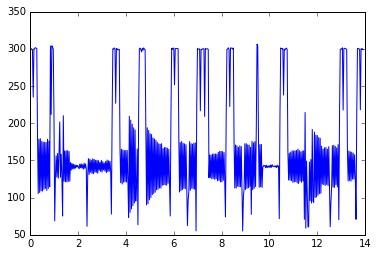

In [4]:
plt.plot(data003walkT, data003walkD)
plt.show()

The signal received for a person riding (or rather quickly walking with) a bike around several times is shown below. We did a real life experiment for this in the library.

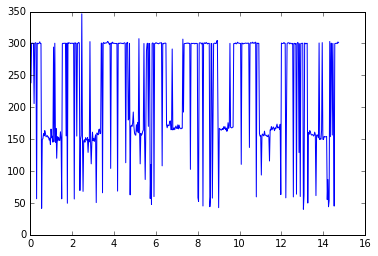

In [5]:
plt.plot(data003bikeT, data003bikeD)
plt.show()

The signal received is very noisy, so we need to filter it. We filter the signal using an IIR or FIR filter, which is implemented in Scipy. The parameters used were tuned so that the filter gave good results. We first show a plot for a person walkign around, and then a bike goign around the sensor.

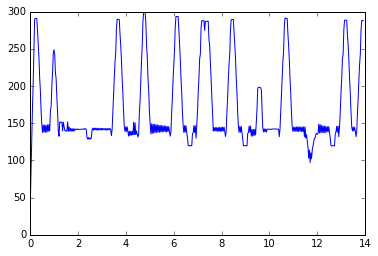

In [6]:
n = 7 # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
data003walk_filtD = lfilter(b, a, data003walkD)
plt.plot(data003walkT[:], data003walk_filtD[:])
plt.show()

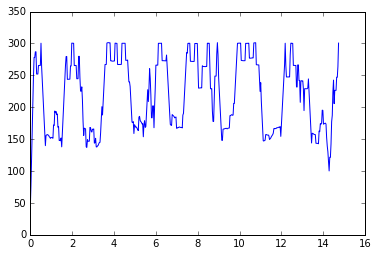

In [7]:
n = 7 # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
data003bike_filtD = lfilter(b, a, data003bikeD)
plt.plot(data003bikeT, data003bike_filtD)
plt.show()

We make an assumption that the bike road is wide 1 m and the road is 1 m before the sensor, so when a sensor gives a distance bigger than 2 m or smaller than 1 m, it is a noise or just saying there is nothing. We filter out the parts where there should be no object present.

In [8]:
data003walk_extractedD = []
data003walk_extractedT = []

for e in range(len(data003walk_filtD)):
    if data003walk_filtD[e] < 200 and data003walk_filtD[e] > 100:
        data003walk_extractedD.append(data003walk_filtD[e])
        data003walk_extractedT.append(data003walkT[e])

data003bike_extractedD = []
data003bike_extractedT = []

for e in range(len(data003bike_filtD)):
    if data003bike_filtD[e] < 200 and data003bike_filtD[e] > 100:
        data003bike_extractedD.append(data003bike_filtD[e])
        data003bike_extractedT.append(data003bikeT[e]) 

So now we have extracted the parts where there is some object going around. Let us show the plots for people and bikes. The plots are connected, so when there is a long line connecting two 'clusters', the line should not be there.

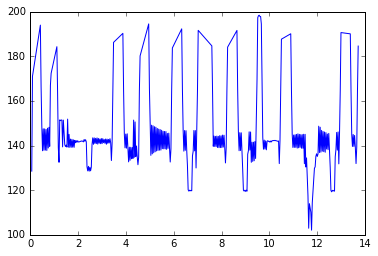

In [9]:
plt.plot(data003walk_extractedT, data003walk_extractedD)
plt.show()

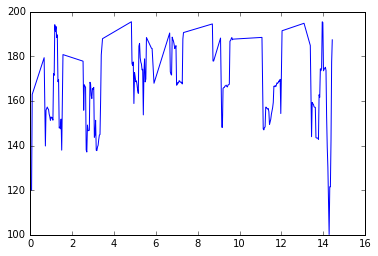

In [10]:
plt.plot(data003bike_extractedT, data003bike_extractedD)
plt.show()

In [11]:
data003walk_extractedT = np.array(data003walk_extractedT).reshape(-1, 1)
data003bike_extractedT = np.array(data003bike_extractedT).reshape(-1, 1)

Now we apply clustering to both extracted signal timeseries. We cluster the points when there was an object present based on the time in which it occurred. For now, we select the number of clusters manually by inspection of the previous plots (the object is going around when there is a more stable decrease in the distance of the object in front of the sensor). In real life, we would select the number of clusters automatically, and we would do the clustering every let's say 10 seconds so that we are doing it fast enough. We would use X-means clustering from pyclustering library, which is capable of selecting the most reasonable number of clusters automatically.

We put the points into clusters, and visualize each of the clusters so that we know it works fine and we can learn the pattern of the given object going around the sensor. So we create some profiles for how the distance measured by the ultrasonic distance sensor changes when there is either a bike or a person going in front of it.

We will create a metric for each cluster, and based on the metric we decide if it is a bike or a person. Of course, the metric is now very simple, and it should be improved later on. Since the boundary points for the metric could be distorted a lot by the points on the boundaries, we take only the middle half of the timeseries into account.

We assume there are 12 instances when a person is going around the sensor and 7 instances when a bike is going around.

Let's first use the algorithm on data of people going around.

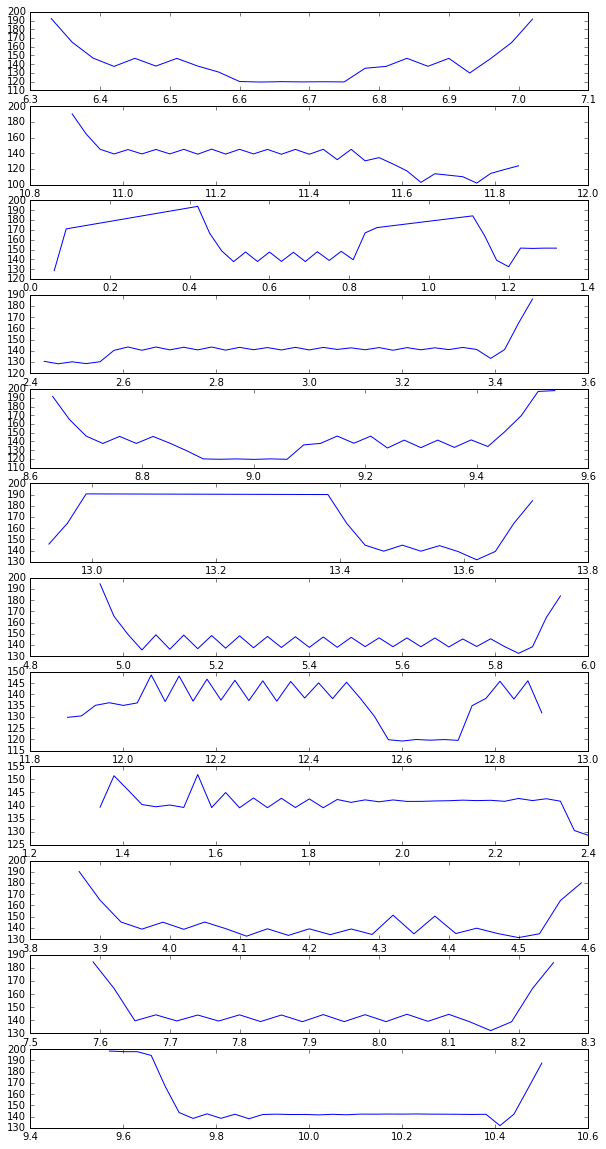

In [12]:
km = KMeans(12)
km.fit(data003walk_extractedT)
indices = km.predict(data003walk_extractedT)
groups_t = [[],[],[],[],[],[],[],[],[],[],[],[]]
groups_d = [[],[],[],[],[],[],[],[],[],[],[],[]]
for e in range(len(indices)):
    groups_t[indices[e]].append(data003walk_extractedT[e])
    groups_d[indices[e]].append(data003walk_extractedD[e])
plt.subplots(12, figsize=(10,20))
metrics_person = []
for i in range(12):
    plt.subplot(12, 1, i+1)
    st = int(len(groups_d[i])*0.25)
    en = int(len(groups_d[i])*0.75)
    plt.plot(groups_t[i], groups_d[i])
    metrics_person.append(np.std(groups_d[i][st:en]))
plt.show()

Now the same for bikes.

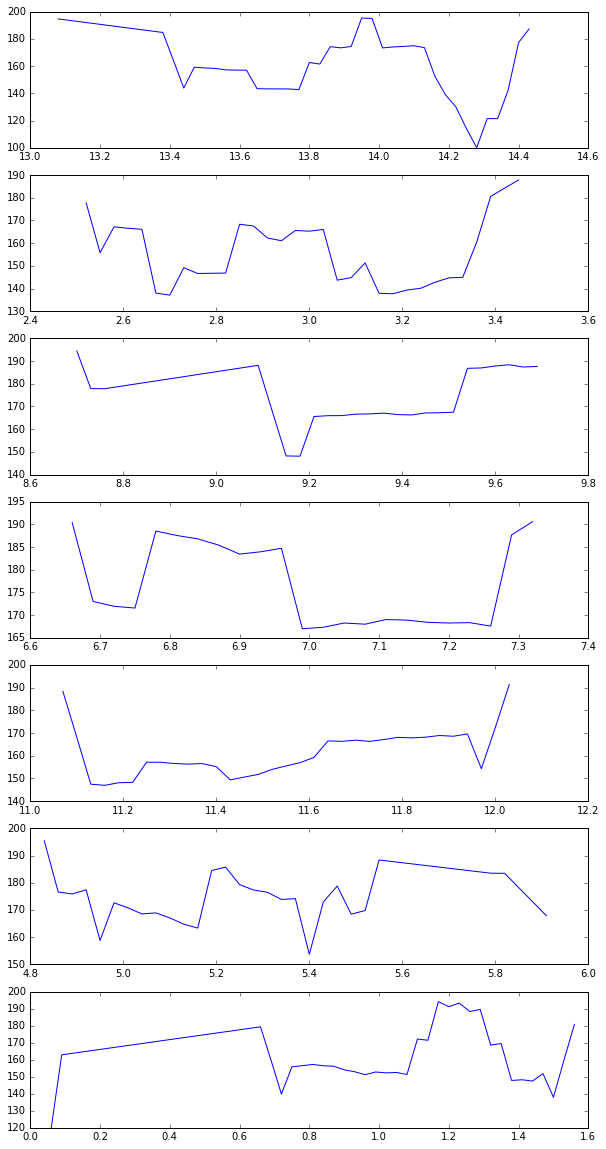

In [13]:
km = KMeans(7)
km.fit(data003bike_extractedT)
indices = km.predict(data003bike_extractedT)
groupsb_t = [[],[],[],[],[],[],[]]
groupsb_d = [[],[],[],[],[],[],[]]
for e in range(len(indices)):
    groupsb_t[indices[e]].append(data003bike_extractedT[e])
    groupsb_d[indices[e]].append(data003bike_extractedD[e])
plt.subplots(7, figsize=(10,20))
metrics_bike = []
for i in range(7):
    st = int(len(groupsb_d[i])*0.25)
    en = int(len(groupsb_d[i])*0.75)
    plt.subplot(7, 1, i+1)
    plt.plot(groupsb_t[i], groupsb_d[i])
    metrics_bike.append(np.std(groupsb_d[i][st:en]))
plt.show()

What we think is happening is that the signal received for a person is much more stable since person is a rather solid object, while a bike has many holes in it, and so it should give a signal which varies much more. This should be reflected in the standard deviation for each cluster.

Metrics results for people:

In [14]:
metrics_person

[10.494154975969485,
 5.888474610686119,
 14.313904604283339,
 1.0961756479504607,
 9.6876952814778701,
 16.670242430341993,
 4.6247736452418815,
 9.2796460449638012,
 1.4919954436289427,
 6.203549419218275,
 2.5743429894210128,
 1.2668123428773228]

Metrics results for bikes:

In [15]:
metrics_bike

[16.565458114850166,
 10.66560457091966,
 5.141479408426668,
 8.6987172072459611,
 6.0185554908129593,
 8.2935453474627998,
 17.197574214083296]

Although not perfect, for the given settings, we could say that a boundary value for std on the given interval is 8. So if the stdev is bigger than 8, we say it is a bike, and if it is less than 8, it is a person. This should be further improved upon since the metric is very simple, but gives to some extent reasonable results. We would misclassify about 33 percent of people for bikes, and about 28 percent of bikes for people. So this should be reasonably better than just classifying everything as person, which should serve as a baseline model.